In [192]:
# Opimize a SVR with Newuoa algorihm 
# Import all bibs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.svm import SVR
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.metrics.pairwise import rbf_kernel
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform




In [193]:
# Set 70 datapoints with a testfunction
np.random.seed(1)
n = 70
lower = [-2.5,-1.5]
upper = [1.5,2.5]
x = np.column_stack((np.random.uniform(lower[0], upper[0], n), np.random.uniform(lower[1], upper[1], n)))
f = lambda x: 20 + x[:,0]**2 + x[:,1]**2 - 10*(np.cos(2*np.pi*x[:,0]) + np.cos(2*np.pi*x[:,1]))
y = f(x)

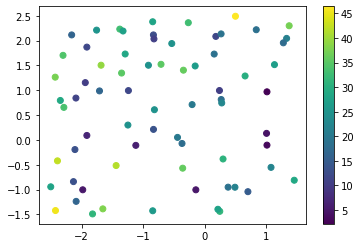

In [194]:

# Create a dataframe with the the datapoints
df = pd.DataFrame({'x.1': x[:, 0], 'x.2': x[:, 1], 'y': y})

# Create a color map using the viridis colorset
cmap = cm.viridis

# Plot the points
plt.scatter(x=df['x.1'], y=df['x.2'], c=df['y'], cmap=cmap)
plt.colorbar()
plt.show()

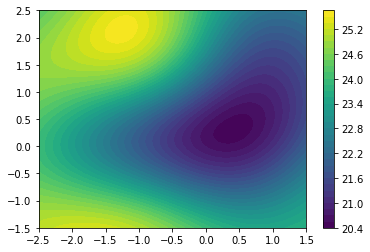

In [195]:
np.random.seed(1)

# Generate a SVR with the datapoints
model = SVR(kernel='rbf', gamma='auto', C=1.0, epsilon=0.1, tol=1e-3)
model.fit(x, y)

nplot_dim = 100

xplot = np.meshgrid(np.linspace(lower[0], upper[0], nplot_dim), 
                    np.linspace(lower[1], upper[1], nplot_dim))
xplot_flat = np.column_stack([xplot[0].ravel(), xplot[1].ravel()])
yplot = model.predict(xplot_flat)

# Plot the SVR
df = pd.DataFrame({'x.1': xplot[0].ravel(), 'x.2': xplot[1].ravel(), 'y': yplot})
cmap = ListedColormap(sns.color_palette("viridis", n_colors=256).as_hex())

plt.contourf(df['x.1'].values.reshape((nplot_dim, nplot_dim)),
             df['x.2'].values.reshape((nplot_dim, nplot_dim)),
             df['y'].values.reshape((nplot_dim, nplot_dim)),
             levels=50,
             cmap=cmap)

plt.colorbar()
plt.show()


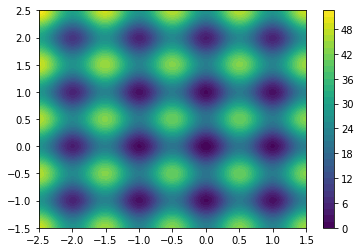

In [196]:
# Plot the testfunction 
yplot2 = f(xplot_flat)
df = pd.DataFrame({'x.1': xplot[0].ravel(), 'x.2': xplot[1].ravel(), 'y': yplot2})
cmap = ListedColormap(sns.color_palette("viridis", n_colors=256).as_hex())

plt.contourf(df['x.1'].values.reshape((nplot_dim, nplot_dim)),
             df['x.2'].values.reshape((nplot_dim, nplot_dim)),
             df['y'].values.reshape((nplot_dim, nplot_dim)),
             levels=50,
             cmap=cmap)

plt.colorbar()
plt.show()


Randomized Search CV

Best hyperparameters: {'C': 2.7390032579527057, 'epsilon': 0.009999724800484167, 'gamma': 'scale', 'tol': 0.0007976388039585665}


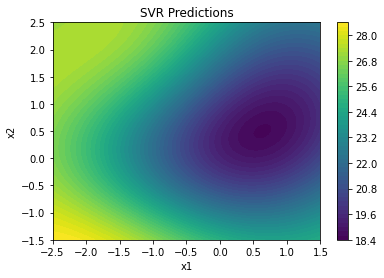

Fehlerwert: 0.06621198741267498
Mean squared error: 111.38200093626409
Objektivwert: -0.9709547721411793


In [197]:
# Define the parameter grid
param_grid = {
    'C': uniform(loc=0, scale=10),
    'epsilon': uniform(loc=0, scale=1),
    'gamma': ['scale', 'auto'],
    'tol': uniform(loc=0, scale=1e-3 )
}

# Create the SVR model
model = SVR(kernel='rbf')

# Perform randomized search
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=100, cv=5, scoring='neg_mean_squared_error', random_state=1)
random_search.fit(x, y)

# Access the best hyperparameters
best_params = random_search.best_params_
print("Best hyperparameters:", best_params)

# Get the best SVR model
best_model = random_search.best_estimator_

# Generate data for plotting
nplot_dim = 200
lower = [-2.5, -1.5]
upper = [1.5, 2.5]
xplot = np.meshgrid(np.linspace(lower[0], upper[0], nplot_dim), np.linspace(lower[1], upper[1], nplot_dim))
xplot_flat = np.column_stack([xplot[0].ravel(), xplot[1].ravel()])
yplot = best_model.predict(xplot_flat)

# Plot the SVR predictions
df = pd.DataFrame({'x.1': xplot[0].ravel(), 'x.2': xplot[1].ravel(), 'y': yplot})
cmap = cm.viridis

plt.contourf(df['x.1'].values.reshape((nplot_dim, nplot_dim)),
             df['x.2'].values.reshape((nplot_dim, nplot_dim)),
             df['y'].values.reshape((nplot_dim, nplot_dim)),
             levels=50,
             cmap=cmap)

plt.colorbar()
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('SVR Predictions')
plt.show()

# Calculate error value
error = best_model.score(x, y)
mse = mean_squared_error(y, best_model.predict(x))

print("Fehlerwert:", error)
print("Mean squared error:", mse)



Unique RS

Best Hyperparameters: [-1.77024702  5.94430178 -3.86451081]


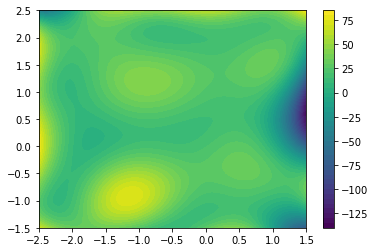

In [198]:

np.random.seed(1)
n = 70
lower = [-2.5, -1.5]
upper = [1.5, 2.5]
x = np.column_stack((np.random.uniform(lower[0], upper[0], n), np.random.uniform(lower[1], upper[1], n)))

def fun(pars):
    np.random.seed(1)
    model = SVR(kernel='rbf', epsilon=10**pars[0], C=10**pars[1], tol=10**pars[2])
    model.fit(x, y)
    return np.mean((model.predict(x) - y) ** 2)  # Mean Squared Error as the evaluation metric

def uniformRandomSearch(x=None, fun=None, lower=None, upper=None, control=None, *args, **kwargs):
    con = {'funEvals': 200}  # default limit on function evaluations
    con.update(control)
    control = con
    npar = len(lower)  # number of parameters
    xtest = np.random.uniform(lower, upper, size=(control['funEvals'], npar))
    ytest = np.array([fun(x, *args, **kwargs) for x in xtest])
    best_index = np.argmin(ytest)
    print("Best Hyperparameters:", xtest[best_index, :])
    return {
        'xbest': xtest[best_index, :],
        'ybest': ytest[best_index],
        'count': xtest.shape[0]
    }

np.random.seed(123)
res = uniformRandomSearch(fun=fun, lower=[-6, -6, -6], upper=[0, 6, 0], control={'funEvals': 200})

model = SVR(kernel='rbf', epsilon=10**res['xbest'][0], C=10**res['xbest'][1], tol=10**res['xbest'][2])
model.fit(x, y)

nplot_dim = 100
xplot = np.meshgrid(np.linspace(lower[0], upper[0], nplot_dim), np.linspace(lower[1], upper[1], nplot_dim))
xplot_flat = np.column_stack([xplot[0].ravel(), xplot[1].ravel()])
yplot = model.predict(xplot_flat)

df = pd.DataFrame({'x.1': xplot[0].ravel(), 'x.2': xplot[1].ravel(), 'y': yplot})

plt.contourf(df['x.1'].values.reshape((nplot_dim, nplot_dim)),
             df['x.2'].values.reshape((nplot_dim, nplot_dim)),
             df['y'].values.reshape((nplot_dim, nplot_dim)),
             levels=50,
             cmap='viridis')

plt.colorbar()
plt.show()





Best Hyperparameters: [-0.37398986  4.896133   -3.9072161  -2.19217158]


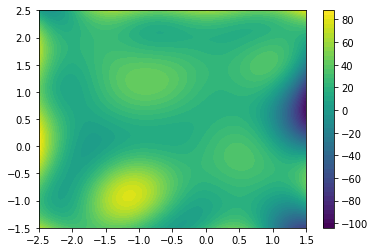

In [199]:
def uniformRandomSearch(x=None, fun=None, lower=None, upper=None, control=None, *args, **kwargs):
    con = {'funEvals': 200}  # default limit on function evaluations
    con.update(control)
    control = con
    npar = len(lower)  # number of parameters
    xtest = np.random.uniform(lower, upper, size=(control['funEvals'], npar))
    ytest = np.array([fun(x, *args, **kwargs) for x in xtest])
    best_index = np.argmin(ytest)
    print("Best Hyperparameters:", xtest[best_index, :])
    return {
        'xbest': xtest[best_index, :],
        'ybest': ytest[best_index],
        'count': xtest.shape[0]
    }

def fun(pars):
    model = SVR(kernel='rbf', gamma=10**pars[0], C=10**pars[1], epsilon=10**pars[2], tol=10**pars[3])
    model.fit(x, y)
    return np.mean((model.predict(x) - y) ** 2)  # Mean Squared Error as the evaluation metric

np.random.seed(123)
res = uniformRandomSearch(fun=fun, lower=[-6, -6, -6, -6], upper=[0, 6, 0, 0], control={'funEvals': 200})

model = SVR(kernel='rbf', gamma=10**res['xbest'][0], C=10**res['xbest'][1], epsilon=10**res['xbest'][2], tol=10**res['xbest'][3])
model.fit(x, y)

nplot_dim = 100
xplot = np.meshgrid(np.linspace(lower[0], upper[0], nplot_dim), np.linspace(lower[1], upper[1], nplot_dim))
xplot_flat = np.column_stack([xplot[0].ravel(), xplot[1].ravel()])
yplot = model.predict(xplot_flat)

# Plot the SVR
df = pd.DataFrame({'x.1': xplot[0].ravel(), 'x.2': xplot[1].ravel(), 'y': yplot})
cmap = ListedColormap(sns.color_palette("viridis", n_colors=256).as_hex())

plt.contourf(df['x.1'].values.reshape((nplot_dim, nplot_dim)),
             df['x.2'].values.reshape((nplot_dim, nplot_dim)),
             df['y'].values.reshape((nplot_dim, nplot_dim)),
             levels=50,
             cmap=cmap)

plt.colorbar()
plt.show()



Best Hyperparameters: [-0.37398986  4.896133   -3.9072161  -2.19217158]


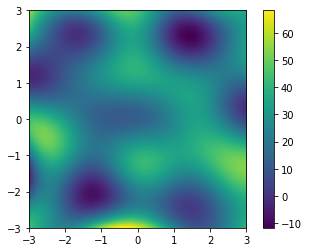

In [200]:
def uniformRandomSearch(x=None, fun=None, lower=None, upper=None, control=None, *args, **kwargs):
    con = {'funEvals': 200}  # default limit on function evaluations
    con.update(control)
    control = con
    npar = len(lower)  # number of parameters
    xtest = np.random.uniform(lower, upper, size=(control['funEvals'], npar))
    ytest = np.array([fun(x, *args, **kwargs) for x in xtest])
    best_index = np.argmin(ytest)
    print("Best Hyperparameters:", xtest[best_index, :])
    return {
        'xbest': xtest[best_index, :],
        'ybest': ytest[best_index],
        'count': xtest.shape[0]
    }

def fun(pars):
    model = SVR(kernel='rbf', gamma=10**pars[0], C=10**pars[1], epsilon=10**pars[2], tol=10**pars[3])
    model.fit(x, y)
    return np.mean((model.predict(x) - y) ** 2)  # Mean Squared Error as the evaluation metric

np.random.seed(123)
res = uniformRandomSearch(fun=fun, lower=[-6, -6, -6, -6], upper=[0, 6, 0, 0], control={'funEvals': 100})

np.random.seed(1)
lower = [-3, -3]
upper = [3, 3]

x = np.column_stack((np.random.uniform(lower[0], upper[0], n), np.random.uniform(lower[1], upper[1], n)))
f = lambda x: 20 + x[:,0]**2 + x[:,1]**2 - 10*(np.cos(2*np.pi*x[:,0]) + np.cos(2*np.pi*x[:,1]))
y = f(x)

model = SVR(kernel='rbf', gamma=10**res['xbest'][0], C=10**res['xbest'][1], tol=10**res['xbest'][2])
model.fit(x, y)
yplot = model.predict(xplot_flat)
df = pd.DataFrame({'x.1': xplot[0].ravel(), 'x.2': xplot[1].ravel(), 'y': yplot})
z = df['y'].values.reshape((nplot_dim, nplot_dim))

plt.imshow(z, extent=[lower[0], upper[0], lower[1], upper[1]], origin='lower', cmap='viridis')
plt.colorbar()
plt.show()




Best Hyperparameters: [-0.29283729  4.8648244  -1.22419835 -0.50835408]


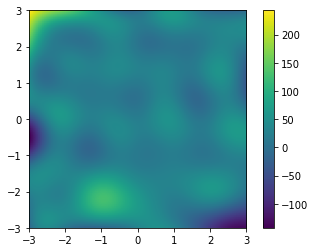

In [201]:
from sklearn.svm import SVR

# Set target function
def target_function(x):
    return 20 + x[:, 0]**2 + x[:, 1]**2 - 10*(np.cos(2*np.pi*x[:, 0]) + np.cos(2*np.pi*x[:, 1]))

# Set random seed
np.random.seed(1)

# Define the range of x
lower = [-3, -3]
upper = [3, 3]

# Generate random data points
x = np.column_stack((np.random.uniform(lower[0], upper[0], n), np.random.uniform(lower[1], upper[1], n)))
y = target_function(x)

# Create meshgrid for plotting
nplot_dim = 100
xplot = np.meshgrid(np.linspace(lower[0], upper[0], nplot_dim), np.linspace(lower[1], upper[1], nplot_dim))
xplot_flat = np.column_stack([xplot[0].ravel(), xplot[1].ravel()])

# Perform uniform random search for best hyperparameters
res = uniformRandomSearch(fun=fun, lower=[-6, -6, -6, -6], upper=[0, 6, 0, 0], control={'funEvals': 100})

# Create SVR model with optimal hyperparameters
model = SVR(kernel='rbf', gamma=10**res['xbest'][0], C=10**res['xbest'][1], epsilon=10**res['xbest'][2], tol=10**res['xbest'][3])
model.fit(x, y)

# Predict the values using the SVR model
yplot = model.predict(xplot_flat)

# Reshape the predicted values for plotting
z = yplot.reshape((nplot_dim, nplot_dim))

# Plot the test function
plt.imshow(z, extent=[lower[0], upper[0], lower[1], upper[1]], origin='lower', cmap='viridis')
plt.colorbar()
plt.show()


